# Policy Gradient - CartPole

This Notebook implements PyTorch's REINFORCE and ACTOR-CRITIC agents for OpenAI's Cartpole.

https://github.com/pytorch/examples/blob/master/reinforcement_learning/reinforce.py
https://github.com/pytorch/examples/blob/master/reinforcement_learning/actor_critic.py



In [1]:
# As usual, a bit of setup
from __future__ import print_function
import time
import numpy as np
import matplotlib.pyplot as plt
import platform
import gym
import random
import torch
import pickle as pickle
import pympler
import gc

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

print("Python version: ", platform.python_version())

Python version:  3.6.3


In [ ]:
env.close()

## PyTorch - Policy Gradient on Cartpole

The following code is PyTorch's official example for REINFORCE Policy Gradient. It trains a RL agent to master the simple game of Cartpole: 

https://github.com/pytorch/examples/blob/master/reinforcement_learning/reinforce.py

The pseudo-code for REINFORCE is as followed:

```
# REINFORCE Pseudo-Code
function REINFORCE
    Initialise θ arbitrarily
    for each episode {s_1 , a_1 , r_2 , ... , s_T−1 , a_T−1 , r_T }~ π_θ do
        for t = 1 to T − 1 do
            θ ← θ + α ∇_θ log (π_θ ( s_t , a_t ) )v_t
    return θ
```

where  
* π_θ is the policy
* v_t is the sample of Q_π_θ(s_t, a_t)
* ∇_θ log ( π_θ ( s_t , a_t ) ) is the score function or log_prob

In [2]:
import argparse
import gym
import numpy as np
from itertools import count

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.distributions import Categorical

gamma=0.99
seed=543
render=False
log_interval=50
verbose=False  # To step through the code and understand what is going on

reinforce=[]

env = gym.make('CartPole-v0')
env.seed(seed)
torch.manual_seed(seed)

# The function approximator of the Policy is a 2 layer NN. 
# - The policy takes in the state of CartPole, which consists of 4 readings.
# - The action is the softmax output (Left or Right)
# - there are 128 hidden units in the NN
class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        self.affine1 = nn.Linear(4, 128)
        self.affine2 = nn.Linear(128, 2)

        self.saved_log_probs = []
        self.rewards = []

    def forward(self, x):
        x = F.relu(self.affine1(x))
        action_scores = self.affine2(x)
        return F.softmax(action_scores, dim=1)

# Call an instance of the Policy and select ADAM as update rule
policy = Policy()
optimizer = optim.Adam(policy.parameters(), lr=1e-2)

def select_action(state):
    """ 
    Use Policy to select an action based on state returned by CartPole
    """
    
    state = torch.from_numpy(state).float().unsqueeze(0)
    if verbose:
        print ("This is CartPole's state output:", state)
    
    # Use Policy to generate probability for action
    probs = policy(Variable(state))
    if verbose:
        print ("This is softmax output from NN:", probs)

    # Sample action stochastically    
    m = Categorical(probs)
    action = m.sample()
    if verbose:
        print ("Action sampled:", action, action.data[0])
        print ("log_prob(action) saved by policy:", m.log_prob(action))
        
    # Store log_prob (score function) into a list for calculating policy gradient    
    policy.saved_log_probs.append(m.log_prob(action))
    
    return action.data[0]  # return the action sampled


def finish_episode():
    """ 
    Based on REINFORCE, policy gradient is calculated at the end of an episode.
    It is then used to update the Policy's weights
    """

    R = 0
    policy_loss = []
    rewards = []   # This is v_t
    
    if verbose:
        print ("Rewards:", policy.rewards)
    
    # In the main loop, reward for each time step is stored in the list policy.rewards[].
    # At the end of the episode, this is used to generate v_t for each time step.
    for r in policy.rewards[::-1]:
        R = r + gamma * R
        rewards.insert(0, R)
    rewards = torch.Tensor(rewards)
    rewards = (rewards - rewards.mean()) / (rewards.std() + np.finfo(np.float32).eps)
    if verbose:
        print ("v_t:", rewards)   

    # Calculate policy gradient ∇_θ log (π_θ ( s_t , a_t ) )v_t
    for log_prob, reward in zip(policy.saved_log_probs, rewards):
        policy_loss.append(-log_prob * reward)   # negative because gradient descent

    if verbose:
        print ("Policy Gradient:", policy_loss)  
        
    optimizer.zero_grad()  # zero the gradients before running the optimizer
    
    # Sum policy gradients for all time steps in the episode
    policy_loss = torch.cat(policy_loss).sum()   
    if verbose:
        print ("Policy loss (after cat and sum):", policy_loss)  
        
    # The TRICK: backward() on policy_loss instead of policy
    # Policy's parameters are updated here.
    policy_loss.backward()  
    optimizer.step()
    
    del policy.rewards[:]
    del policy.saved_log_probs[:]
    
    return policy_loss.data[0]


# Main loop
running_reward = 10
for i_episode in count(1):  # Infinite loop
# for i_episode in range(1): # just run 1 episode    
    state = env.reset()
    
    for t in range(10000):  # Don't infinite loop while learning
        
        # Sample an action from Policy based on state provided by env
        action = select_action(state)
        
        # step env through the sampled action
        state, reward, done, _ = env.step(action)
        
        if render:
            env.render()
            
        # append reward to policy.reward[]
        # this is needed to calculate policy gradient at the end of the episode  
        policy.rewards.append(reward)
        
        # break if episode is done
        if done:
            break

    running_reward = running_reward * 0.99 + t * 0.01   # calculate running reward
    
    # Calculate policy gradient and update Policy 
    loss = finish_episode()
    
    reinforce.append([t, running_reward, loss/t])
    
    # print out and show sign of life
    if i_episode % log_interval == 0:
        print('Episode {}\tLast length: {:5d}\tAverage length: {:.2f}\tLoss: {:.2f}'.format(
                i_episode, t, running_reward, loss/t))
    if running_reward > env.spec.reward_threshold:
        print("Solved! Running reward is now {} and "
                  "the last episode runs to {} time steps!".format(running_reward, t))
        break


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Episode 50	Last length:    28	Average length: 10.84	Loss: 0.03
Episode 100	Last length:    42	Average length: 20.58	Loss: -0.04
Episode 150	Last length:    72	Average length: 30.69	Loss: 0.04
Episode 200	Last length:    40	Average length: 41.11	Loss: -0.03
Episode 250	Last length:    74	Average length: 39.69	Loss: 0.13
Episode 300	Last length:   132	Average length: 52.62	Loss: 0.04
Episode 350	Last length:   108	Average length: 69.47	Loss: 0.01
Episode 400	Last length:    85	Average length: 79.72	Loss: 0.04
Episode 450	Last length:   171	Average length: 108.03	Loss: 0.03
Episode 500	Last length:   199	Average length: 143.93	Loss: -0.01
Episode 550	Last length:   199	Average length: 165.50	Loss: -0.04
Episode 600	Last length:   199	Average length: 178.73	Loss: -0.01
Episode 650	Last length:   199	Average length: 186.74	Loss: -0.11
Episode 700	Last length:   124	Average length: 187.69	Loss:

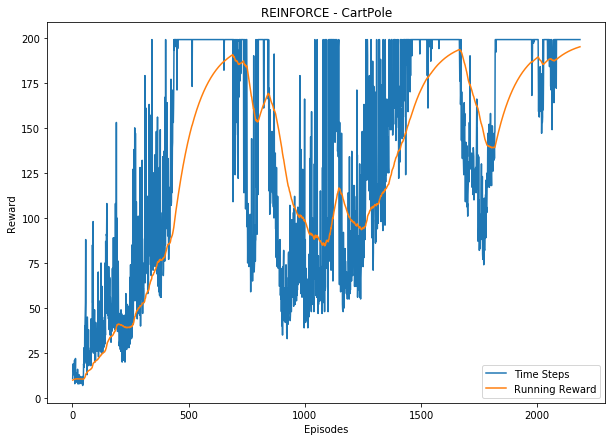

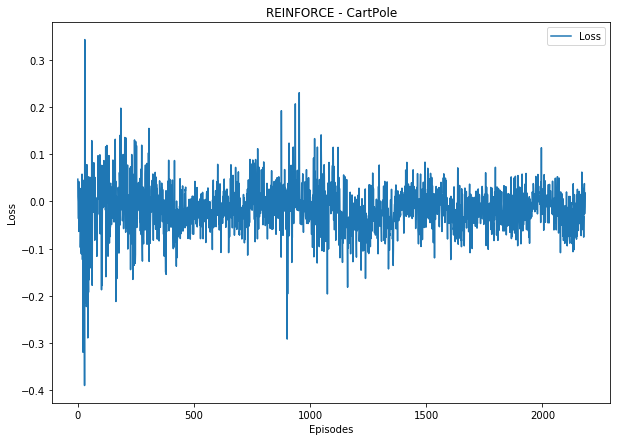

In [3]:
# Plot out reward and running reward over training episodes
plt.figure(figsize=(10, 7))

plt.plot(list(range(1,len(np.array(reinforce)[:,0])+1)), np.array(reinforce)[:,0], label='Time Steps')
plt.plot(list(range(1,len(np.array(reinforce)[:,1])+1)), np.array(reinforce)[:,1], label='Running Reward')
plt.title('REINFORCE - CartPole')
plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.legend()
plt.show()

# Plot out Polic Loss over training episodes
plt.figure(figsize=(10, 7))

plt.plot(list(range(1,len(np.array(reinforce)[:,2])+1)), np.array(reinforce)[:,2], label='Loss')
plt.title('REINFORCE - CartPole')
plt.xlabel('Episodes')
plt.ylabel('Loss')
plt.legend()
plt.show()

## PyTorch - Actor-Critic on Cartpole

The following code is PyTorch's official example for Actor-Critic Policy Gradient. It trains a RL agent to master the simple game of Cartpole: 

https://github.com/pytorch/examples/blob/master/reinforcement_learning/actor_critic.py

The pseudo-code for ACTOR-CRITIC is as followed:

```
# Q Actor-Critic Pseudo-Code
    function QAC
    Initialise s, θ
    Sample a ∼ π_θ # sample an action
    for each step do
        Sample reward r = R_sa ; sample transition s′ = P_sa ;
        # sample next action according to our policy
        Sample action a′ ~ π_θ(s′, a′)
        δ = r + γQ_w(s′, a′) − Q_w(s, a) # get TD error
        θ = θ + α∇_θ log π_θ(s, a)Q_w(s, a) # update actor policy
        w ← w + βδ∅(s, a)
        # update critic
        a ← a′ , s ← s′
```


In [4]:
import argparse
import gym
import numpy as np
from itertools import count
from collections import namedtuple

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.distributions import Categorical

gamma=0.99
seed=1
render=False
log_interval=50
verbose=False  # To step through the code and understand what is going on

actorCritic=[]

env = gym.make('CartPole-v0')
env.seed(seed)
torch.manual_seed(seed)

# This is saved as a list and used to update the Actor and Critic's parameters
SavedAction = namedtuple('SavedAction', ['log_prob', 'value'])

# The function approximators for the Actor and the Critic is ia a two 2-layer NN with 2 heads
# - the NN takes in the state of CartPole, which consists of 4 readings.
# - there are 128 hidden units in the NN
# - The action_head (Actor) computes softmax output for actions (L and R) 
# - The value_head (Critic) computes an estimate for the value function Q_w(s, a)
class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        self.affine1 = nn.Linear(4, 128)
        self.action_head = nn.Linear(128, 2)
        self.value_head = nn.Linear(128, 1)  

        self.saved_actions = []
        self.rewards = []

    def forward(self, x):
        x = F.relu(self.affine1(x))
        action_scores = self.action_head(x)
        state_values = self.value_head(x)
        return F.softmax(action_scores, dim=-1), state_values

# Call an instance of the Policy and select ADAM as update rule
model = Policy()
optimizer = optim.Adam(model.parameters(), lr=3e-2)

def select_action(state):
    """ 
    Use Policy to select an action based on state returned by CartPole
    """

    state = torch.from_numpy(state).float()
    # Use Policy to generate probability for actions and value function
    probs, state_value = model(Variable(state))

    # Sample action stochastically    
    m = Categorical(probs)
    action = m.sample()
    
    # Store log_prob (score function) and value function into a list to update Actor and Critic 
    # parameters later on
    model.saved_actions.append(SavedAction(m.log_prob(action), state_value))
    
    return action.data[0]   # return sampled action


def finish_episode():
    """ 
    In this implementation, Actor and Critic parameters are updated at the end of an episode.
    """

    R = 0
    saved_actions = model.saved_actions
    policy_losses = []
    value_losses = []
    rewards = []     # This is v_t
    
    # In the main loop, reward for each time step is stored in the list policy.rewards[].
    # At the end of the episode, this is used to generate v_t for each time step.
    for r in model.rewards[::-1]:
        R = r + gamma * R
        rewards.insert(0, R)
    rewards = torch.Tensor(rewards)
    rewards = (rewards - rewards.mean()) / (rewards.std() + np.finfo(np.float32).eps)

    # Calculate gradient for Actor and Critic
    for (log_prob, value), r in zip(saved_actions, rewards):
        # Actor's policy gradient is computed here
        reward = r - value.data[0]   
        policy_losses.append(-log_prob * reward)
        
        # Critic's value gradient is computed here
        value_losses.append(F.smooth_l1_loss(value, Variable(torch.Tensor([r]))))

    optimizer.zero_grad()# zero the gradients before running the optimizer
    
    # Sum Actor and Critic gradients for all time steps in the episode
    loss = torch.stack(policy_losses).sum() + torch.stack(value_losses).sum()

    # The TRICK: backward() on loss instead of policy
    # Actor's and Critic's parameters are updated here.
    loss.backward()
    optimizer.step()
    
    del model.rewards[:]
    del model.saved_actions[:]


# Main Loop
running_reward = 10
for i_episode in count(1):
    state = env.reset()
    for t in range(10000):  # Don't infinite loop while learning
        action = select_action(state)
        state, reward, done, _ = env.step(action)
        if render:
            env.render()
        model.rewards.append(reward)
        if done:
            break

    running_reward = running_reward * 0.99 + t * 0.01
    finish_episode()
    
    actorCritic.append([t, running_reward])
    
    if i_episode % log_interval == 0:
        print('Episode {}\tLast length: {:5d}\tAverage length: {:.2f}'.format(
                i_episode, t, running_reward))
    if running_reward > env.spec.reward_threshold:
        print("Solved! Running reward is now {} and "
                  "the last episode runs to {} time steps!".format(running_reward, t))
        break



WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Episode 50	Last length:    48	Average length: 34.00
Episode 100	Last length:   136	Average length: 56.87
Episode 150	Last length:   199	Average length: 84.54
Episode 200	Last length:    71	Average length: 71.54
Episode 250	Last length:    91	Average length: 74.32
Episode 300	Last length:   131	Average length: 101.30
Episode 350	Last length:   165	Average length: 128.76
Episode 400	Last length:   199	Average length: 147.89
Episode 450	Last length:    14	Average length: 130.50
Episode 500	Last length:   199	Average length: 130.88
Episode 550	Last length:   197	Average length: 124.19
Episode 600	Last length:   199	Average length: 142.17
Episode 650	Last length:   162	Average length: 159.47
Episode 700	Last length:   132	Average length: 149.71
Episode 750	Last length:   199	Average length: 158.56
Episode 800	Last length:   199	Average length: 174.54
Episode 850	Last length:   199	Average leng

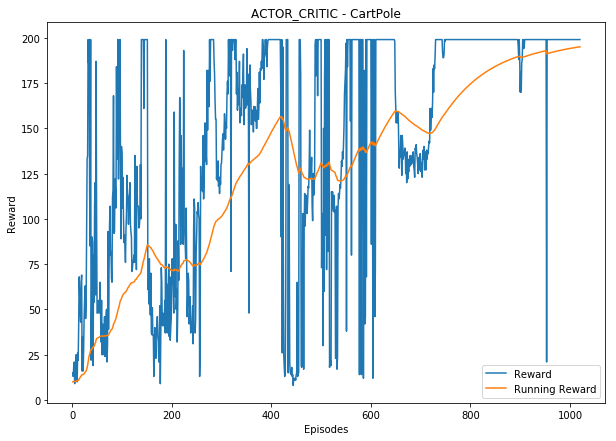

In [5]:
# Plot out reward and running reward over training episodes
plt.figure(figsize=(10, 7))

plt.plot(list(range(1,len(np.array(actorCritic)[:,0])+1)), np.array(actorCritic)[:,0], label='Reward')
plt.plot(list(range(1,len(np.array(actorCritic)[:,1])+1)), np.array(actorCritic)[:,1], label='Running Reward')
plt.title('ACTOR_CRITIC - CartPole')
plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.legend()
plt.show()

# Actor-Critic's Superiority

The Actor-Critic solves the Cartpole problem in under 1000 episodes, while REINFORCE requires over 2000. REINFORCE also exhibit higher volatility in the agent's learning.

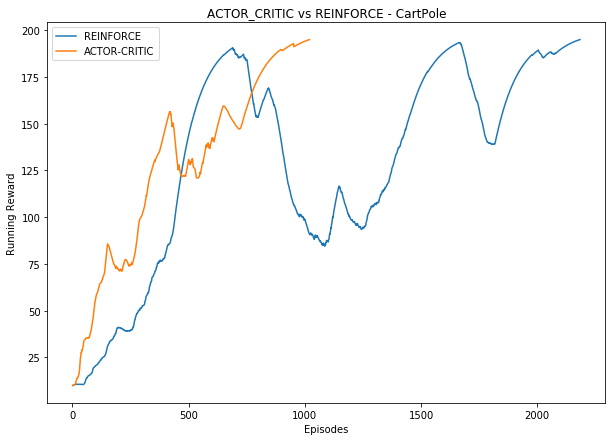

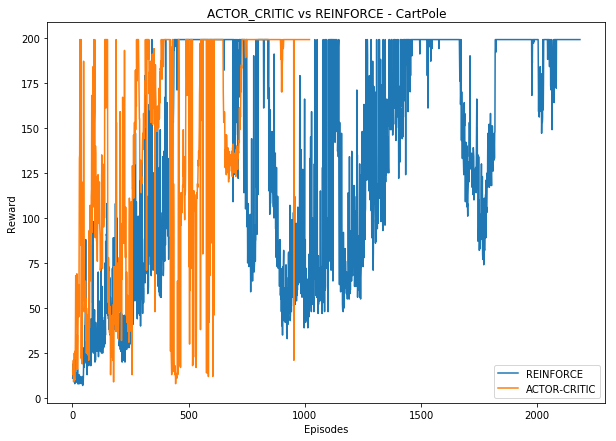

In [6]:
# Plot out running rewards of Actor-Critic vs REINFORCE
plt.figure(figsize=(10, 7))

plt.plot(list(range(1,len(np.array(reinforce)[:,1])+1)), np.array(reinforce)[:,1], label='REINFORCE')
plt.plot(list(range(1,len(np.array(actorCritic)[:,1])+1)), np.array(actorCritic)[:,1], label='ACTOR-CRITIC')
plt.title('ACTOR_CRITIC vs REINFORCE - CartPole')
plt.xlabel('Episodes')
plt.ylabel('Running Reward')
plt.legend()
plt.show()

# Plot out rewards of Actor-Critic vs REINFORCE
plt.figure(figsize=(10, 7))

plt.plot(list(range(1,len(np.array(reinforce)[:,0])+1)), np.array(reinforce)[:,0], label='REINFORCE')
plt.plot(list(range(1,len(np.array(actorCritic)[:,0])+1)), np.array(actorCritic)[:,0], label='ACTOR-CRITIC')
plt.title('ACTOR_CRITIC vs REINFORCE - CartPole')
plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.legend()
plt.show()